In [1]:
import decode
import torch
import matplotlib.pyplot as plt

print(f"DECODE version: {decode.utils.bookkeeping.decode_state()}")

DECODE version: vINVALID-recent-0.10.0


# DECODE - Evaluation
In the following we show what DECODE provides in terms of evaluation.
Please be advised to have a read of the Introduction notebook first.
Evaluation always acts on two sets of emitters, mostly prediction and reference (i.e. ground truth). In the following we show some toy examples.

## Evaluation Pipeline
The evaluation workflow is almost always
1. Definition of reference and candidate (=prediction) EmitterSet
2. Matching of reference and candidate
3. Evaluation of Detection and Localization Metrics

In [2]:
# dummy emittersets
em_ref = decode.RandomEmitterSet(200, xy_unit='px', px_size=(100., 100.))
em_ref.frame_ix = torch.randint_like(em_ref.frame_ix, low=0, high=20)

em_pred = em_ref.clone()  # make independent copy
em_pred = em_pred[torch.rand(len(em_pred)) <= 0.8]  # through away random subset of 20%
em_pred.xyz += torch.randn_like(em_pred.xyz)  # wiggle coordinates a bit around

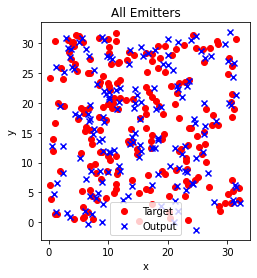

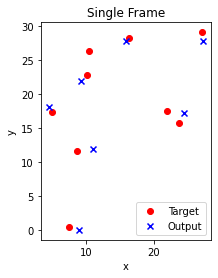

In [3]:
# plot all emitters
decode.plot.PlotCoordinates(pos_tar=em_ref.xyz_px, 
                            pos_out=em_pred.xyz_px).plot()
plt.legend()
plt.title('All Emitters')
plt.show()

# plot on a selected frame
decode.plot.PlotCoordinates(pos_tar=em_ref[em_ref.frame_ix == 10].xyz_px, 
                            pos_out=em_pred[em_pred.frame_ix == 10].xyz_px).plot()
plt.legend()
plt.title('Single Frame')
plt.show()

## Matching
We perform matching like in the superres fight club (THE challenge). This means that one defines a search radius in which predictions are considered true positives. We have 1:1 matches.

In [3]:
matcher = decode.evaluation.match_emittersets.GreedyHungarianMatching(match_dims=3, dist_lat=250, dist_ax=500.)  # always in nm

tp, fp, fn, tp_match = matcher.forward(em_pred, em_ref)  # outputs true positives, false positives, false negatives, matched ground truth

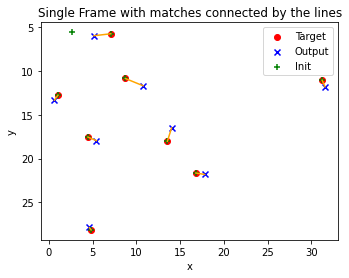

In [4]:
# plot
# plot on a selected frame
decode.plot.PlotCoordinates(pos_tar=tp_match[tp_match.frame_ix == 10].xyz_px, 
                            pos_out=tp[tp.frame_ix == 10].xyz_px,
                            pos_ini=em_ref[em_ref.frame_ix == 10].xyz_px,
                            match_lines=True).plot()

plt.legend()
plt.title('Single Frame with matches connected by the lines')
plt.show()

## Performance Evaluation
Below we perform the actual evaluation which is found in the convenience class `SMLMEvaluation`. Note that some of the evaluation metrices, i.e. the CRLB based ones, require special inputs which can not be computed from two emittersets alone. In Order to evaluate also those, you need to specify a PSF function, provide background estimates and calculate the CRLB:

    emitter.populate_crlb(psf)
    
If these values are not present, a warning will be issued (`UserWarning: Non-Finite values encountered during fitting.`), it can be safely ignored though.

In [7]:
evaluator = decode.evaluation.SMLMEvaluation()

result = evaluator.forward(tp, fp, fn, tp_match)

In [8]:
# performance values
result._asdict()

{'prec': 0.9612903225806452,
 'rec': 0.745,
 'jac': 0.7233009708737864,
 'f1': 0.83943661971831,
 'effcy_lat': -0.300209534098579,
 'effcy_ax': 0.7232614284064325,
 'effcy_vol': 0.21152594715392675,
 'rmse_lat': 127.04261016845703,
 'rmse_ax': 0.9356129169464111,
 'rmse_vol': 127.04605102539062,
 'mad_lat': 140.79188537597656,
 'mad_ax': 0.7344900965690613,
 'mad_vol': 141.5263671875,
 'dx_red_mu': nan,
 'dx_red_sig': nan,
 'dy_red_mu': nan,
 'dy_red_sig': nan,
 'dz_red_mu': nan,
 'dz_red_sig': nan,
 'dphot_red_mu': nan,
 'dphot_red_sig': nan}

In [9]:
# more readable description of the metrices.
evaluator.descriptors

{'pred': 'Precision',
 'rec': 'Recall',
 'jac': 'Jaccard Index',
 'rmse_lat': 'RMSE lateral',
 'rmse_ax': 'RMSE axial',
 'rmse_vol': 'RMSE volumetric',
 'mad_lat': 'Mean average distance lateral',
 'mad_ax': 'Mean average distance axial',
 'mad_vol': 'Mean average distance in 3D',
 'dx_red_sig': 'CRLB normalised error in x',
 'dy_red_sig': 'CRLB normalised error in y',
 'dz_red_sig': 'CRLB normalised error in z',
 'dx_red_mu': 'CRLB normalised bias in x',
 'dy_red_mu': 'CRLB normalised bias in y',
 'dz_red_mu': 'CRLB normalised bias in z'}